In [1]:
from pyspark.sql import SparkSession, functions as F
from pyspark.ml import feature as H
# First lets reed the datasets
spark = (
    SparkSession.builder.appName("Data_Explorer")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

22/10/12 22:56:13 WARN Utils: Your hostname, James-N580VD-DM229T resolves to a loopback address: 127.0.1.1; using 172.30.26.19 instead (on interface eth0)
22/10/12 22:56:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/12 22:56:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [118]:
merchant_info = spark.read.parquet('../data/curated/full_dataset_Variation/')

In [119]:
linkage = spark.read.csv('../data/curated/sector_lookup_table.csv', header=True)

In [121]:
# pre process industry
merchant_desc = merchant_info.select('merchant_abn', 'Description').distinct()

In [122]:
merchant_desc = merchant_desc.join(linkage, on= merchant_desc.Description == linkage.Description, how='inner')

In [123]:
merchant_desc = merchant_desc.select('merchant_abn', 'sector').distinct()

In [160]:
# Read all our tables 
customer_scaled = spark.read.parquet('../data/Normalised/customer_scaled/')
customer_scaled = customer_scaled.fillna(0.5)
industry_raw = spark.read.parquet('../data/Normalised/industry_scailed/')
industry_raw = industry_raw.fillna(0.5)
merchant_scaled = spark.read.parquet('../data/Normalised/merchant_scaled/')
merchant_scaled = merchant_scaled.fillna(0.5)
revenue_scaled = spark.read.parquet('../data/Normalised/revenue_scailed/')
revenue_scaled = revenue_scaled.fillna(0.5)

In [161]:
revenue_scaled.orderBy(F.col('Total_Revenue').desc())

merchant_abn,Total_Revenue,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Growth_4,Growth_5,Growth_6,Growth_7,Growth_8,Growth_9,Revenue_Growth_Avg
79827781481,1.0,27401.715,55649.880000000005,89379.21600000001,119941.119,153069.516,187679.39399999997,219812.55299999996,0.5076051376930193,0.3773733705607801,0.254807552695919,0.216427136282315,0.18440957881609513,0.14618436736868248,0.4917
48534649627,0.9593,25108.155000000002,51791.49000000002,81973.41300000004,112003.43400000007,144307.39500000008,177195.069,209601.333,0.5152069384371836,0.3681916111020046,0.26811696684228453,0.22385520159933586,0.1856015191935161,0.15460905489565765,0.5001
32361057556,0.9567,25323.300000000007,51574.80599999998,81549.09899999999,112258.188,144135.12600000002,176515.36200000008,209036.0249999998,0.5089986378232811,0.36756130193418823,0.2735576758106946,0.22116009389688965,0.18344146159924624,0.15557444225223735,0.4985
86578477987,0.9536,25288.515,51318.485999999975,81484.236,111847.50900000012,143479.72800000024,176419.65600000037,209129.41500000036,0.5072240634690585,0.3702035078294166,0.2714702658241596,0.22046472655705104,0.18671348049788772,0.15640917371666696,0.4992
45629217853,0.9079,24032.44800000001,49599.108000000124,78863.11500000034,107269.91400000094,136904.4840000012,168456.04400000005,199304.97999999896,0.5154661249149893,0.3710734352808672,0.2648160881344638,0.21646164635484105,0.18729847413488382,0.15478256489124892,0.4985
38700038932,0.9064,23678.964,50980.28399999999,79461.07199999999,108283.149,137158.35300000003,168848.145,200449.67399999997,0.5355270284488803,0.35842441189315943,0.2661732436318417,0.2105245751966708,0.18768220403013583,0.15765318231447953,0.5003
96680767841,0.896,25367.832000000002,50179.346999999994,79972.02000000002,107039.52000000003,136344.83399999997,166588.55099999995,196569.12599999987,0.49445671343630665,0.37253870791309285,0.2528738918111741,0.21493527213506267,0.18154739217342725,0.1525192465880931,0.4864
21439773999,0.883,23642.343,48253.76100000003,75715.18700000005,103824.00500000005,133041.245,162956.69699999996,192893.7229999999,0.5100414452668262,0.3626937618208617,0.2707352504847023,0.21961039225091397,0.18357915047824006,0.15519958625092206,0.4961
63123845164,0.8667,22274.019000000004,45205.26299999999,72821.565,100205.06400000001,128043.04499999998,156004.11899999995,187340.74199999997,0.5072693416251111,0.3792324704913992,0.2732746021698066,0.2174111135829359,0.17923292140767114,0.16727073174504684,0.5025
64403598239,0.8567,22603.382999999998,46465.52399999999,73456.443,100052.51399999997,128039.08500000004,157656.50100000016,187075.44000000035,0.5135450748387126,0.36744113787268473,0.26582111669877656,0.21857834269902868,0.18786041686920413,0.15725708837033944,0.4987


In [162]:
dd = merchant_info.where(F.col('merchant_abn') == 79827781481).select(F.sum('BNPL_Revenue'))

In [163]:
merchant_scaled

merchant_abn,postcode_entropy,Customer_Growth_Avg,Total_Business_Days
34440496342,0.3315,0.3917,7.0E-4
35344855546,0.1248,0.4575,0.0053
37935728745,0.6698,0.7152,0.0
38700038932,0.0295,0.4225,0.0246
38986645707,0.5364,0.5512,1.0E-4
41956465747,0.3028,0.4328,0.001
35079621278,0.5876,0.4143,1.0E-4
35769589414,0.2178,0.4632,0.002
37470904997,0.4963,0.5343,2.0E-4
39759375662,0.4393,0.4188,3.0E-4


In [164]:
# slip ups 
industry_scaled = merchant_desc.join(industry_raw, on='sector').drop('sector')
revenue_scaled = revenue_scaled.select('merchant_abn', 'Revenue_Growth_Avg','Total_Revenue')

In [165]:
from operator import add
from functools import reduce
# For each table we need to perform the following steps
def scroring_process(dataset, toggle=False):
    # first subtract 1 from each cell then square
    for col in dataset.columns[1:]:
        dataset = dataset.withColumn(col, F.pow((F.col(col) - 1),2))
    # sum the columns 
    if toggle != False:
        dataset.withColumn('Industry_score', F.col('Industry_score') * toggle)
    new_df = dataset.withColumn('total',F.round(reduce(add, [F.col(x) for x in dataset.columns[1:]]), 8))
    return new_df


In [166]:
# Define our scaliong function
def feature_standardisation(dataset): 
    values = dataset.select(F.max('total').alias('high'), F.min('total').alias('low'))
    dataset = dataset.withColumn('total', F.round((F.col('total') - values.select('low').head()[0]) / (values.select('high').head()[0] - values.select('low').head()[0]), 9))
    return dataset.select('merchant_abn', 'total')

In [167]:
# score industry, then add to merchants 
industry_scaled = scroring_process(industry_scaled)
industry_scaled = industry_scaled.select('merchant_abn','total')
industry_scaled = feature_standardisation(industry_scaled)
industry_scaled = industry_scaled.withColumnRenamed('total','Industry_score')
merchant_scaled = merchant_scaled.join(industry_scaled, on='merchant_abn', how='left')

In [168]:
customer_scaled = scroring_process(customer_scaled)
merchant_scaled = scroring_process(merchant_scaled)
revenue_scaled = scroring_process(revenue_scaled)

In [169]:
revenue_scaled.where(F.col('merchant_abn') == 79827781481)

merchant_abn,Revenue_Growth_Avg,Total_Revenue,total
79827781481,0.25836888999999996,0.0,0.25836889


In [170]:
# rescale them 
customer_scaled = customer_scaled.select('merchant_abn','total')
customer_scaled = feature_standardisation(customer_scaled)
customer_scaled = customer_scaled.withColumnRenamed('total','Customer_score')
revenue_scaled = revenue_scaled.select('merchant_abn','total')
revenue_scaled = feature_standardisation(revenue_scaled)
revenue_scaled = revenue_scaled.withColumnRenamed('total','Revenue_score')
merchant_scaled = merchant_scaled.select('merchant_abn','total')
merchant_scaled = feature_standardisation(merchant_scaled)
merchant_scaled = merchant_scaled.withColumnRenamed('total','Merchant_score')

In [172]:
revenue_scaled.where(F.col('merchant_abn') == 79827781481)

merchant_abn,Revenue_score
79827781481,0.003896705


In [174]:
# Finally join 
Full_scores = customer_scaled.join(revenue_scaled, on='merchant_abn', how='inner').join(merchant_scaled, on='merchant_abn', how='inner')

In [175]:
# now scale and done 
#Industry_scale_factor = 1
Full_scores = Full_scores.withColumn('total',F.round(reduce(add, [F.col(x) for x in Full_scores.columns[1:]]), 8))

In [176]:
Full_scores = Full_scores.join(merchant_desc.join(industry_raw, on='sector').select('merchant_abn', 'sector').distinct(), on='merchant_abn', how='left')

In [2]:
Full_scores.write.parquet('../data/Normalised/Final_scores_alt', mode='overwrite')

NameError: name 'Full_scores' is not defined

For determining the top merchant 

In [3]:
Full_scores = spark.read.parquet('../data/Normalised/Final_scores_alt/')

In [4]:
merchant = spark.read.parquet('../data/processed/merchants/')

In [15]:
# top scorer
Full_scores.join(merchant, on='merchant_abn', how='left').orderBy('total').toPandas()

,merchant_abn,Customer_score,Revenue_score,Merchant_score,total,sector,name,tags,avg_monthly_inc,monthly_entropy,postcode_entropy,revenue
0,24852446429,0.000000,0.206028,0.204711,0.410739,Administrative_Support_Services,Erat Vitae LLP,"[(florists supplies, nursery stock, and floWer...",-17.095238,2.986862,7.991211,8.698780e+06
1,43186523025,0.093969,0.077551,0.247475,0.418995,Administrative_Support_Services,Lorem Ipsum Sodales Industries,"([florists supplies, nurSery stock, and flower...",-7.047619,2.986498,7.989193,9.041986e+06
2,86578477987,0.002165,0.000799,0.666151,0.669114,Personal_Services,Leo In Consulting,"[[watch, clock, and jewelry repair shops], [a]...",-16.333334,2.987301,7.990691,9.539821e+06
3,45629217853,0.062840,0.004821,0.684570,0.752231,Personal_Services,Lacus Consulting,"[[gift, Card, novelty, and souvenir shops], [a...",-12.619047,2.985442,7.987784,8.395063e+06
4,89726005175,0.071851,0.018109,0.693644,0.783605,Personal_Services,Est Nunc Consulting,"((tent and awning shops), (a), (take rate: 6.01))",-12.523809,2.986330,7.988224,8.908821e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
4003,24526454463,0.829210,0.997600,0.678194,2.505004,Personal_Services,Penatibus Limited,"((jewelry, watch, clock, and silverware shops)...",1.500000,0.562335,1.386294,2.820073e+04
4004,13467303030,0.925934,0.989404,0.605058,2.520396,Personal_Services,Duis LLP,"[(tent and awning shops), (a), (take rate: 5.51)]",0.142857,1.831020,2.197225,1.441240e+04
4005,15704713883,0.892656,0.891800,0.747864,2.532321,Arts_Recreation_Services,Faucibus Ut Nulla Ltd,"((bicycle shops - sales and service), (c), (ta...",-0.071429,2.518879,3.295837,1.182762e+04
4006,76866488151,0.811011,0.824856,0.903317,2.539184,Personal_Services,Euismod Urna Company,"((antique shops - sales, repairs, and restorat...",0.000000,1.039721,1.386294,4.128598e+04


Text(0, 0.5, 'Frequency of Merchants')

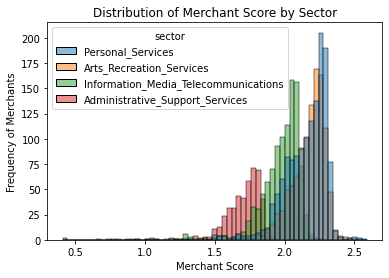

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(x='total', hue='sector', data=Full_scores.toPandas())
plt.title('Distribution of Merchant Score by Sector')
plt.xlabel('Merchant Score')
plt.ylabel('Frequency of Merchants')


In [191]:
top_100 = Full_scores.orderBy('total').limit(100)

In [196]:
top_100_pd = top_100.groupBy('sector').count().toPandas()
top_100_pd

,sector,count
0,Administrative_Support_Services,46
1,Personal_Services,25
2,Information_Media_Telecommunications,24
3,Arts_Recreation_Services,5


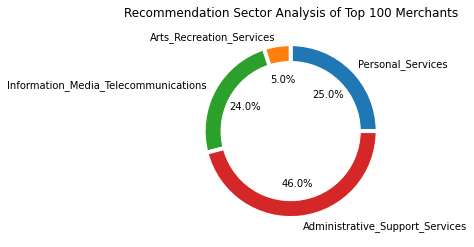

In [203]:
# library
import matplotlib.pyplot as plt

# create data
names = ['Personal_Services', 'Arts_Recreation_Services', 'Information_Media_Telecommunications', 'Administrative_Support_Services']
size = [25,5,24,46]
 
# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.8, color='white')

# Custom wedges
plt.pie(size, labels=names, wedgeprops = { 'linewidth' : 4, 'edgecolor' : 'white' }, autopct="%.1f%%")
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Recommendation Sector Analysis of Top 100 Merchants')
plt.show()

# Now do the Bar plot 

In [220]:
# For top 600
top_600 = Full_scores.orderBy('total').limit(500)

In [221]:
trans = spark.read.parquet('../data/curated/full_dataset_Variation/')

In [222]:
trans100 = trans.join(top_100, on='merchant_abn', how = 'inner')
trans600 = trans.join(top_600, on='merchant_abn', how = 'inner')

In [223]:
trans100.select(F.sum('BNPL_Revenue'))

sum(BNPL_Revenue)
2.543357883000118E7


In [224]:
trans600.select(F.sum('BNPL_Revenue'))

sum(BNPL_Revenue)
4.537336444999871E7


Text(0, 0.5, 'Total BNPL Revenue for Company set ($ in Thousands)')

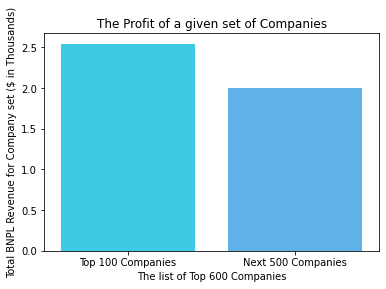

In [238]:
sns.barplot(x=['Top 100 Companies', 'Next 500 Companies'],y=[2.5433, 1.993978], palette= sns.color_palette("cool"))
plt.title('The Profit of a given set of Companies')
plt.xlabel('The list of Top 600 Companies')
plt.ylabel('Total BNPL Revenue for Company set ($ in Thousands)')

In [239]:
Full_scores

merchant_abn,Customer_score,Revenue_score,Merchant_score,total,sector
34440496342,0.900218315,0.590184705,0.804685957,2.29508898,Personal_Services
35344855546,0.77881397,0.564613193,0.912329493,2.25575666,Personal_Services
37935728745,0.866273681,0.458020862,0.517233011,1.84152755,Personal_Services
38700038932,0.487368431,0.003949421,0.993720114,1.48503797,Personal_Services
38986645707,0.90209826,0.556936419,0.620260315,2.07929499,Arts_Recreation_S...
41956465747,0.892203226,0.55556633,0.800219597,2.24798915,Personal_Services
12516851436,0.901277122,0.535597784,0.775668389,2.21254329,Personal_Services
15613631617,0.740149066,0.579221043,0.939802168,2.25917228,Personal_Services
19839532017,0.872221804,0.576414358,0.697688624,2.14632479,Information_Media...
73256306726,0.556291602,0.464696563,0.983190445,2.00417861,Arts_Recreation_S...


# Distribution of scores


<AxesSubplot:xlabel='Customer_score'>

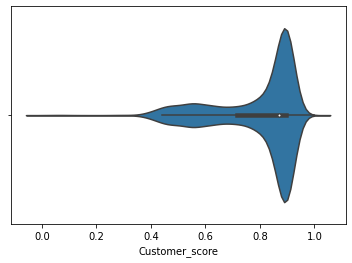

In [241]:
sns.violinplot(x='Customer_score', data=Full_scores.toPandas())

Text(0, 0.5, 'Distribution (Between 0 & 1)')

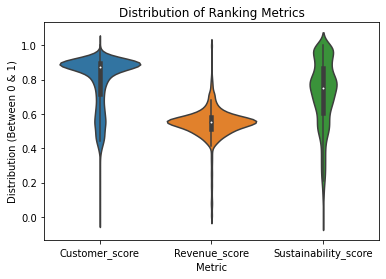

In [18]:
Full_scores = Full_scores.withColumnRenamed('Merchant_score', 'Sustainability_score')
sns.violinplot(data=Full_scores.select('Customer_score', 'Revenue_score', 'Sustainability_score').toPandas())
plt.title('Distribution of Ranking Metrics')
plt.xlabel('Metric')
plt.ylabel('Distribution (Between 0 & 1)')


# Top 10

In [246]:
top_100_pd = top_100.orderBy('total').limit(10)

In [247]:
top_100_pd = top_100_pd.toPandas()

In [252]:
top_100_pd = top_100_pd.sort_values(by='total')

,merchant_abn,Customer_score,Revenue_score,Merchant_score,total,sector
0,24852446429,0.000000,0.206028,0.204711,0.410739,Administrative_Support_Services
1,43186523025,0.093969,0.077551,0.247475,0.418995,Administrative_Support_Services
2,86578477987,0.002165,0.000799,0.666151,0.669114,Personal_Services
3,45629217853,0.062840,0.004821,0.684570,0.752231,Personal_Services
4,89726005175,0.071851,0.018109,0.693644,0.783605,Personal_Services
5,49891706470,0.058646,0.070159,0.674258,0.803063,Personal_Services
6,21439773999,0.242242,0.009179,0.626347,0.877769,Information_Media_Telecommunications
7,63290521567,0.198028,0.178919,0.539175,0.916122,Information_Media_Telecommunications
8,68216911708,0.157675,0.257834,0.540582,0.956090,Information_Media_Telecommunications
9,64203420245,0.038321,0.252930,0.668789,0.960040,Personal_Services


[Text(0, 0.5, 'Ranking Score')]

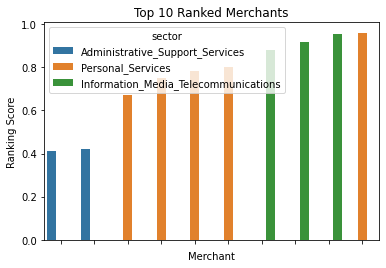

In [265]:
plot_order = top_100_pd.sort_values(by='total').merchant_abn.values
plot = sns.barplot(x='merchant_abn', y='total', hue='sector', data=top_100_pd, order=plot_order)
plot.set(xticklabels=[])
plot.set(title='Top 10 Ranked Merchants')
plot.set(xlabel='Merchant')
plot.set(ylabel='Ranking Score')


<AxesSubplot:xlabel='merchant_abn', ylabel='total'>

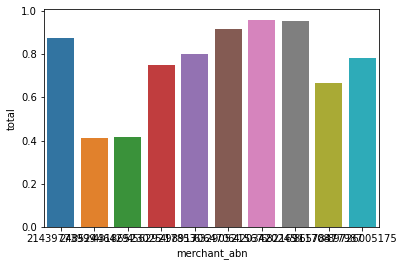

In [253]:
sns.barplot(x='merchant_abn', y='total', data=top_100_pd)